# __Stroke probability prediction Challenge__

<div style="color:#00ADB5;
           display:fill;
           border-radius:10px;
           background-color:#393E46;
           font-size:30px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 5px; padding-left:20px;
              color:white;">
            <b>   1. Data Analysis</b>
        </p>
</div>

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>1.1. Analyze target feature</b>
        </p>
</div>


In [648]:
#imports
import numpy as np
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from colorama import Fore, Style
import matplotlib.colors as mpl_colors
from cycler import cycler
from dython.nominal import associations
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [649]:
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#0a84ff', '#ff9f0a', '#30d158', '#ff453a', '#bf5af2', '#5e5ce6', '#ff375f', '#64d2ff', '#ffd60a']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
white_color = '#d1d1d6'

palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': grey_palette[-2],
    'figure.edgecolor': grey_palette[-2],
    'axes.facecolor': grey_palette[-2],
    'text.color':white_color,
    'axes.labelcolor':white_color,
    'axes.edgecolor':white_color,
    'xtick.color':white_color,
    'ytick.color':white_color,
    'figure.dpi':150,
}

sns.set_theme(
    style='ticks',
    palette=sns.color_palette(palette),
    rc=custom_params
)

In [650]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train["stroke"].describe()

count    15304.000000
mean         0.041296
std          0.198981
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: stroke, dtype: float64

In [651]:
train.head()

id  gender   age  hypertension  heart_disease ever_married work_type  \
0   0    Male  28.0             0              0          Yes   Private   
1   1    Male  33.0             0              0          Yes   Private   
2   2  Female  42.0             0              0          Yes   Private   
3   3    Male  56.0             0              0          Yes   Private   
4   4  Female  24.0             0              0           No   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban              79.53  31.1     never smoked       0  
1          Rural              78.44  23.9  formerly smoked       0  
2          Rural             103.00  40.3          Unknown       0  
3          Urban              64.87  28.8     never smoked       0  
4          Rural              73.36  28.8     never smoked       0

In [652]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [653]:
plt.figure(figsize=(10, 10))
print("stroke number : ", train["stroke"].value_counts()[0], "out of ", len(train)) 

stroke number :  14672 out of  15304


<Figure size 1500x1500 with 0 Axes>

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>1.2. Univariate analysis</b>
        </p>
</div>


In [654]:
# concat train and test data
X = pd.concat([train.drop("stroke", axis=1), test], axis=0)
y = train["stroke"]
X.drop("id", axis=1, inplace=True)

# determine which data are numerical and which are categorical
numerical_features = X.select_dtypes(exclude=['object']).copy()
numerical_features = numerical_features.drop(["hypertension", "heart_disease"], axis=1)

categorical_features = X.select_dtypes(include=['object']).copy()
categorical_features["hypertension"] = X["hypertension"].astype("object")
categorical_features["heart_disease"] = X["heart_disease"].astype("object")

In [655]:
print(categorical_features)

       gender ever_married work_type Residence_type   smoking_status  \
0        Male          Yes   Private          Urban     never smoked   
1        Male          Yes   Private          Rural  formerly smoked   
2      Female          Yes   Private          Rural          Unknown   
3        Male          Yes   Private          Urban     never smoked   
4      Female           No   Private          Rural     never smoked   
...       ...          ...       ...            ...              ...   
10199  Female           No   Private          Urban     never smoked   
10200    Male          Yes   Private          Urban          Unknown   
10201  Female           No  children          Rural          Unknown   
10202    Male          Yes   Private          Urban     never smoked   
10203  Female           No  children          Urban          Unknown   

      hypertension heart_disease  
0                0             0  
1                0             0  
2                0            

In [656]:
print(numerical_features)

        age  avg_glucose_level   bmi
0      28.0              79.53  31.1
1      33.0              78.44  23.9
2      42.0             103.00  40.3
3      56.0              64.87  28.8
4      24.0              73.36  28.8
...     ...                ...   ...
10199  27.0              75.77  17.6
10200  49.0             102.91  26.7
10201   3.0             104.04  18.3
10202  31.0              82.41  28.7
10203   2.0              85.12  14.8

[25508 rows x 3 columns]


In [657]:
#this fixes a plot problem if value is int,float instead of object
categorical_features["hypertension"].replace({0: "No", 1: "Yes"}, inplace=True)
categorical_features["heart_disease"].replace({0: "No", 1: "Yes"}, inplace=True)
categorical_features.head()

C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\2309966971.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  categorical_features["hypertension"].replace({0: "No", 1: "Yes"}, inplace=True)
C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\2309966971.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

gender ever_married work_type Residence_type   smoking_status hypertension  \
0    Male          Yes   Private          Urban     never smoked           No   
1    Male          Yes   Private          Rural  formerly smoked           No   
2  Female          Yes   Private          Rural          Unknown           No   
3    Male          Yes   Private          Urban     never smoked           No   
4  Female           No   Private          Rural     never smoked           No   

  heart_disease  
0            No  
1            No  
2            No  
3            No  
4            No

<a id="num_feat"></a>
#### [__1.2.1 Numerical Features__](#num_feat)

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

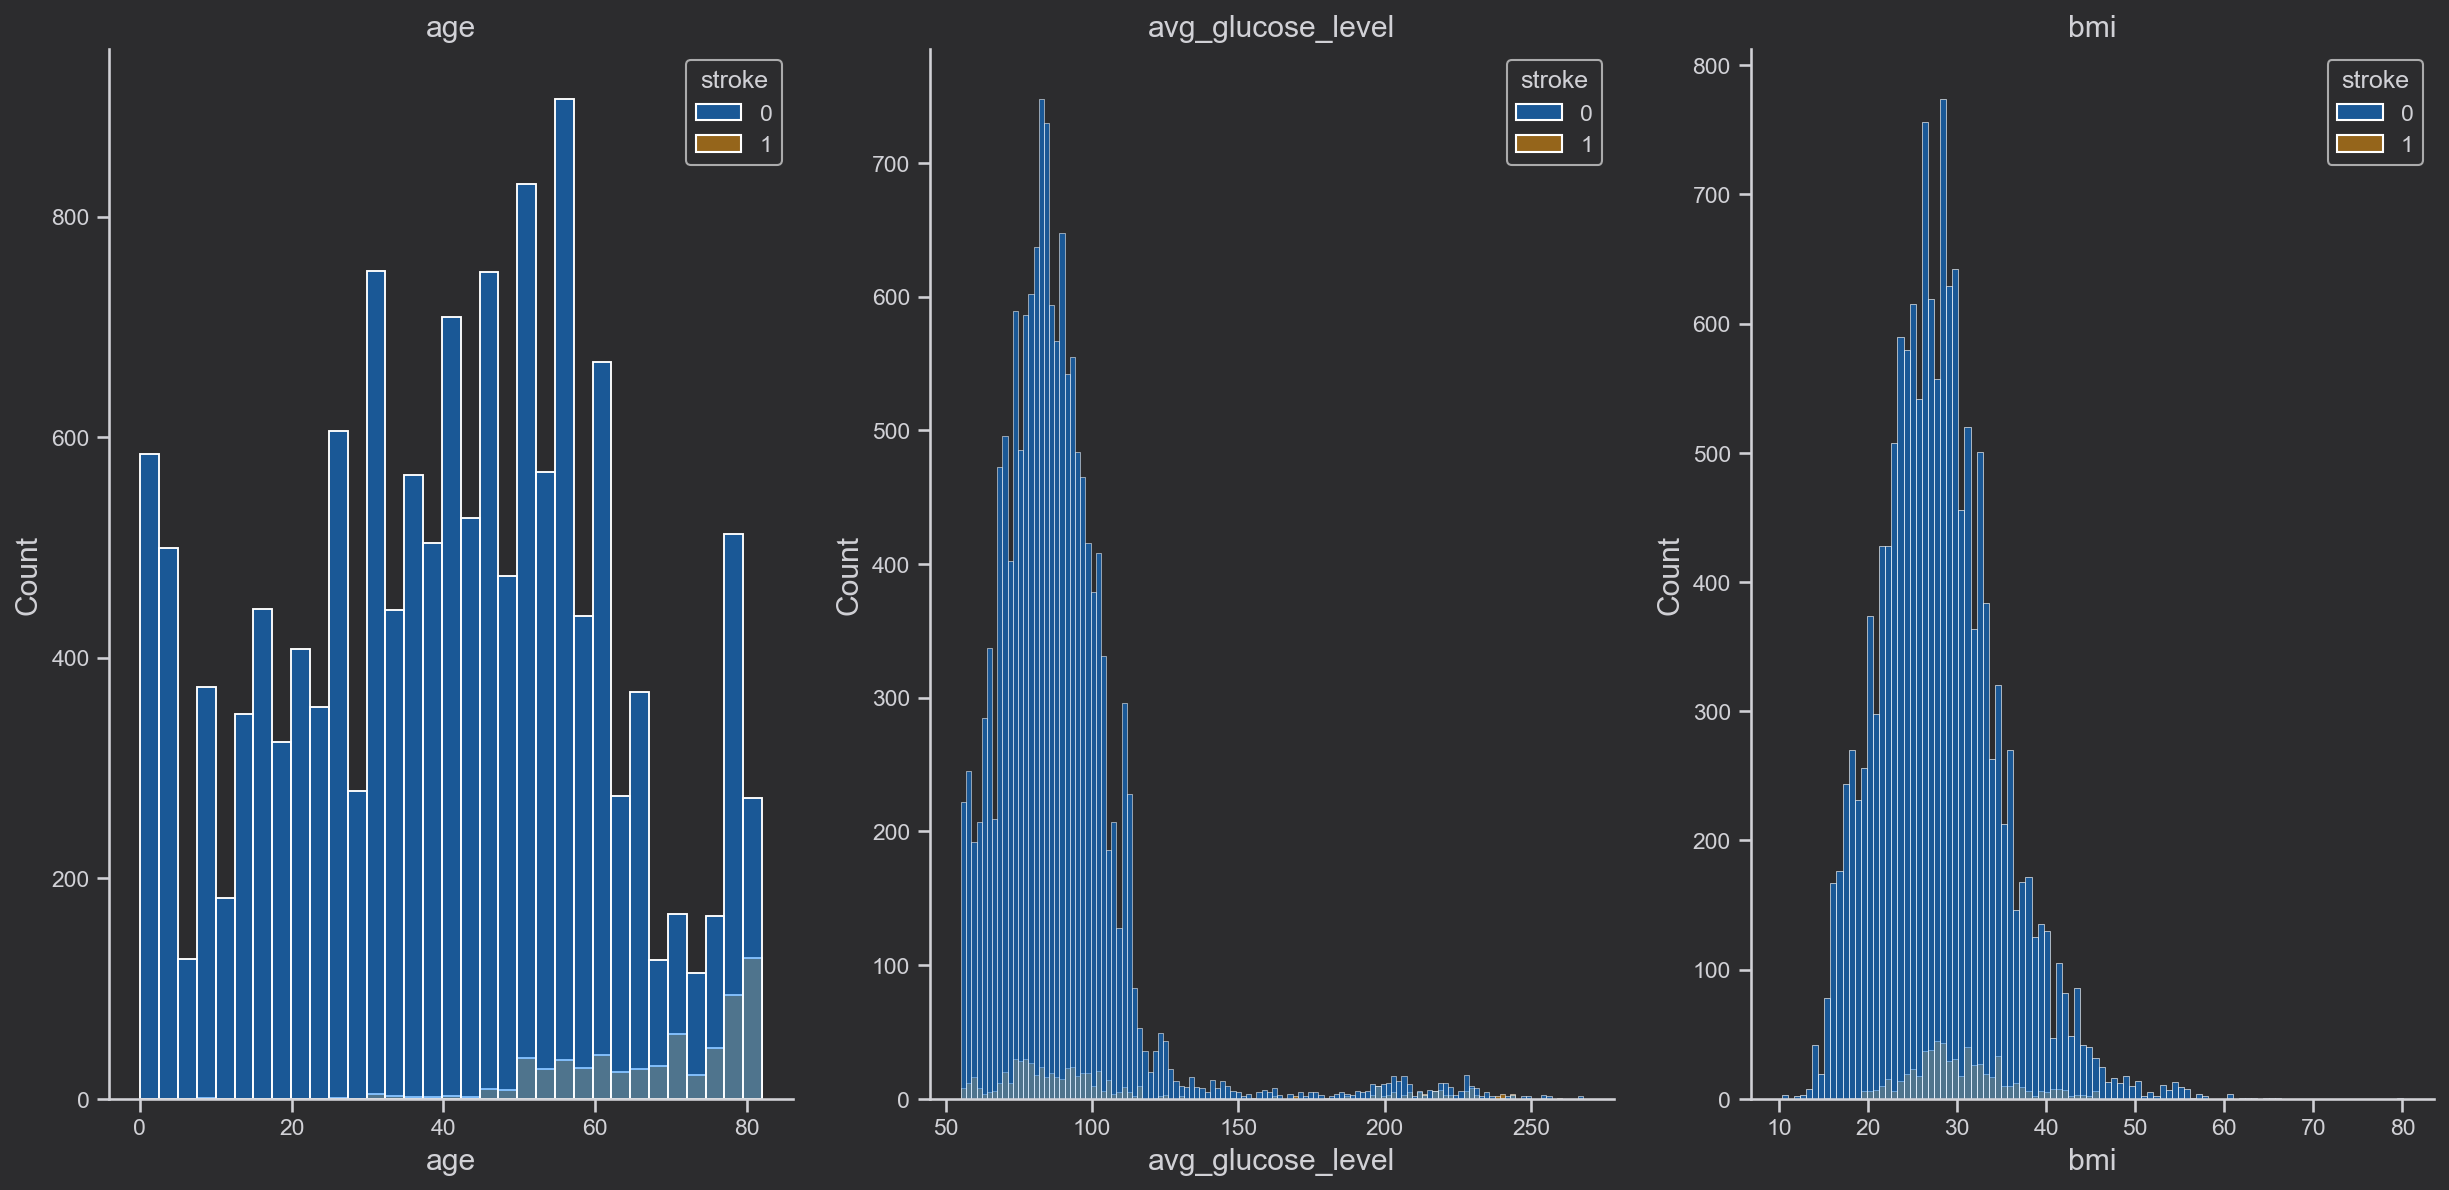

In [658]:
# plot numerical features
plt.figure(figsize=(20, 20))
col = len(numerical_features.columns)
rows = col // 3 + 1

for index, col in enumerate(numerical_features.columns):
    plt.subplot(rows, 3, index+1)
    sns.histplot(x = col, data = train, hue = "stroke", kde = False)
    plt.title(col)
plt.show()


<a id="num_feat"></a>
#### [__1.2.1 Numerical Features plot test__](#num_feat)

0 age


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 avg_glucose_level


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 bmi


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


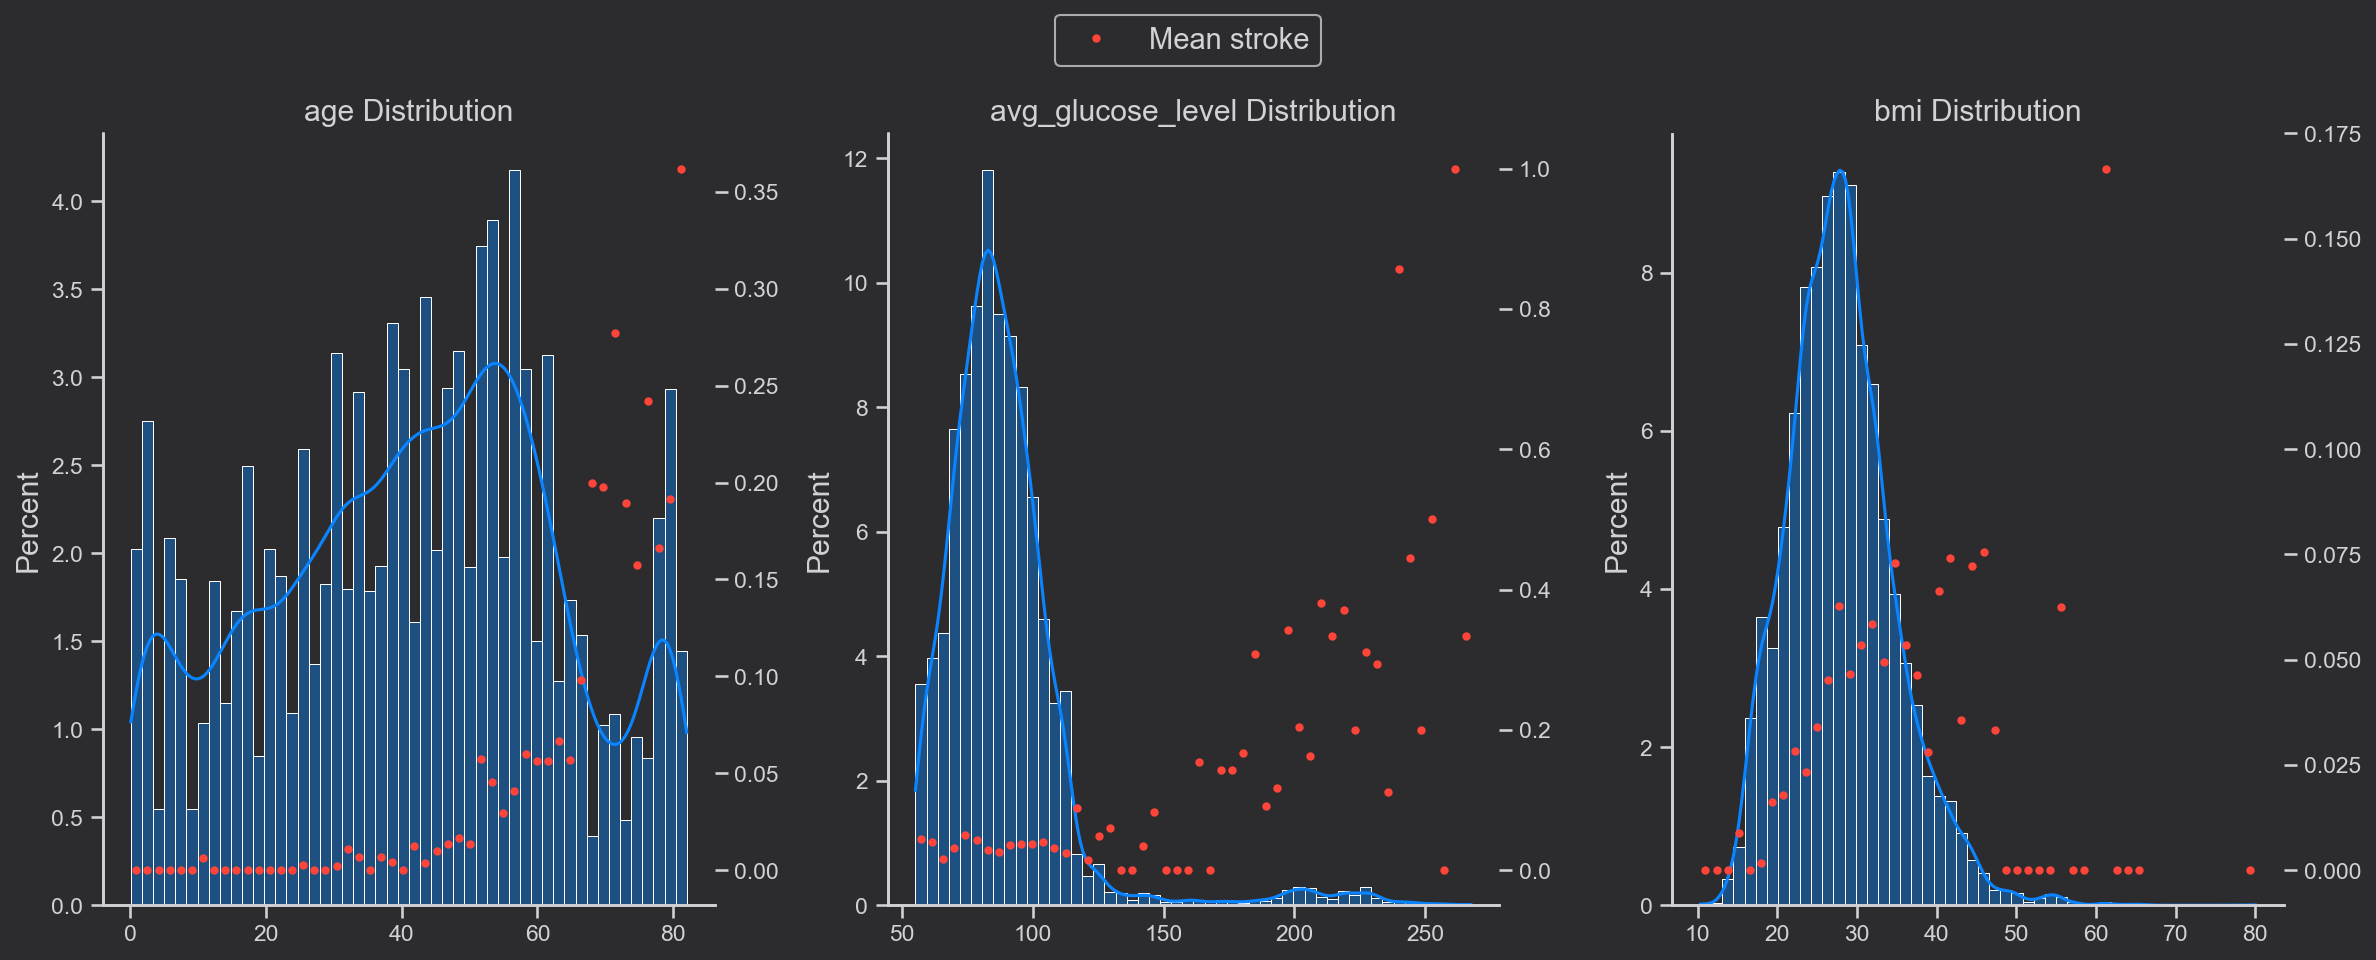

In [659]:
#function to plot the mean of the target
def secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker='.', color=colors[color], label=f'Mean {target_column}'
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

col = len(numerical_features.columns)
rows = col // 3 + 1
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax = ax.flatten()

for index, col in enumerate(numerical_features):
    plot_axes = [ax[index]]
    print(index, col)
    sns.histplot(data =train, x = col, common_norm=False, ax = ax[index], **histplot_hyperparams)
    ax2 = secondary_plot(df=train, column=col, target_column='stroke', ax=ax[index], n_bins=n_bins, color=3, show_yticks=True)
    # titles
    ax[index].set_title(f'{col} Distribution')
    ax[index].set_xlabel(None)
    
    # remove legends to show only one at the end
    plot_axes = [ax[index], ax2]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        if plot_ax.get_legend() is not None:
            handles += plot_ax.get_legend().legendHandles
            labels += [x.get_text() for x in plot_ax.get_legend().get_texts()]
        else:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            
        plot_ax.legend().remove()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), fontsize=14, ncol=3)
plt.tight_layout()
plt.show()

Link between bmi and the target: 

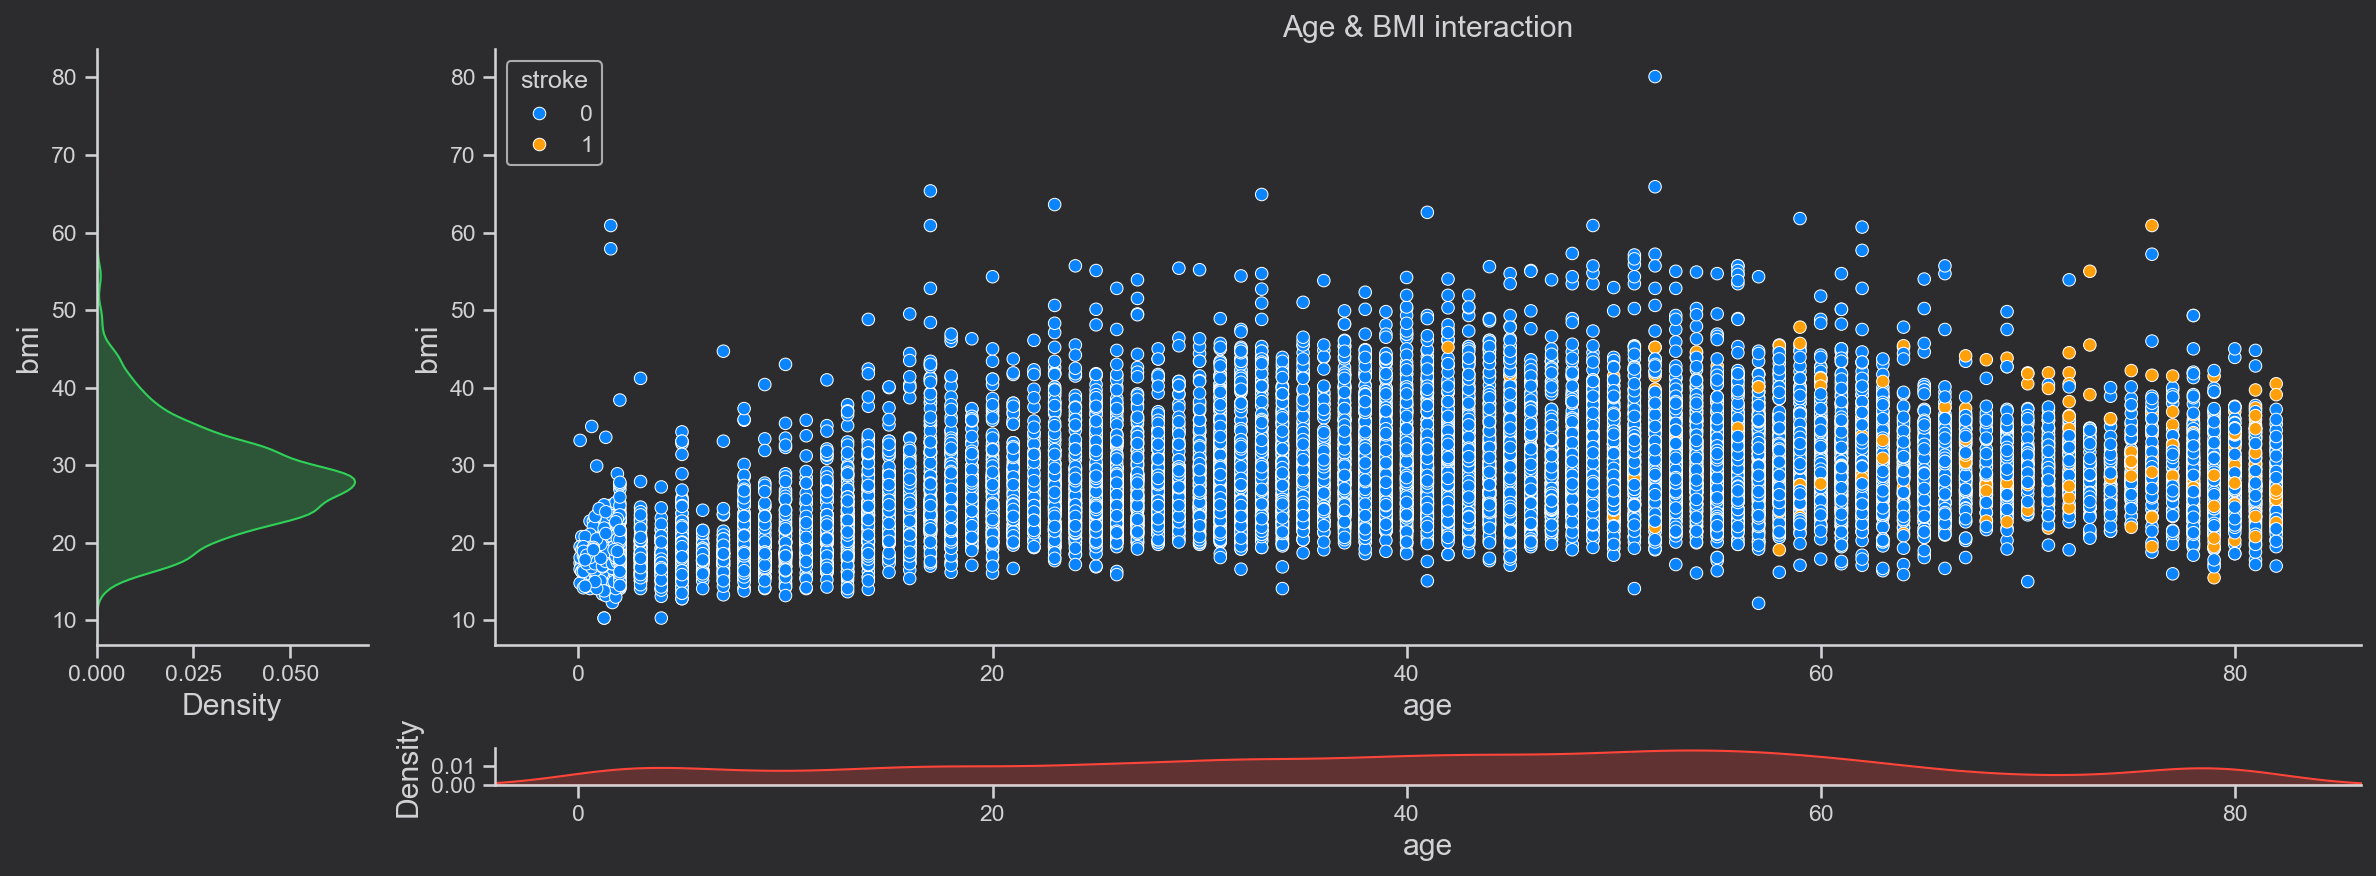

In [660]:
fig = plt.figure()
gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:5, 1:])
ax2 = fig.add_subplot(gs[:5, 0])
ax3 = fig.add_subplot(gs[5, 1:])

sns.scatterplot(x=train.age, y=train.bmi, hue=train.stroke, ax=ax1)
sns.kdeplot(y=train.bmi, ax=ax2, color=colors[2], fill=True)
sns.kdeplot(x=train.age, ax=ax3, color=colors[3], fill=True)

ax1.set_title('Age & BMI interaction')
legend = ax1.legend(loc='upper left')
legend.set_title('stroke')

ax2.set_ylim(ax1.get_ylim())
ax3.set_xlim(ax1.get_xlim())
plt.tight_layout()

<a id="num_feat"></a>
#### [__1.2.2 Categorical Features__](#num_feat)

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

0 gender
1 ever_married


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

2 work_type
3 Residence_type


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

4 smoking_status
5 hypertension


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


6 heart_disease


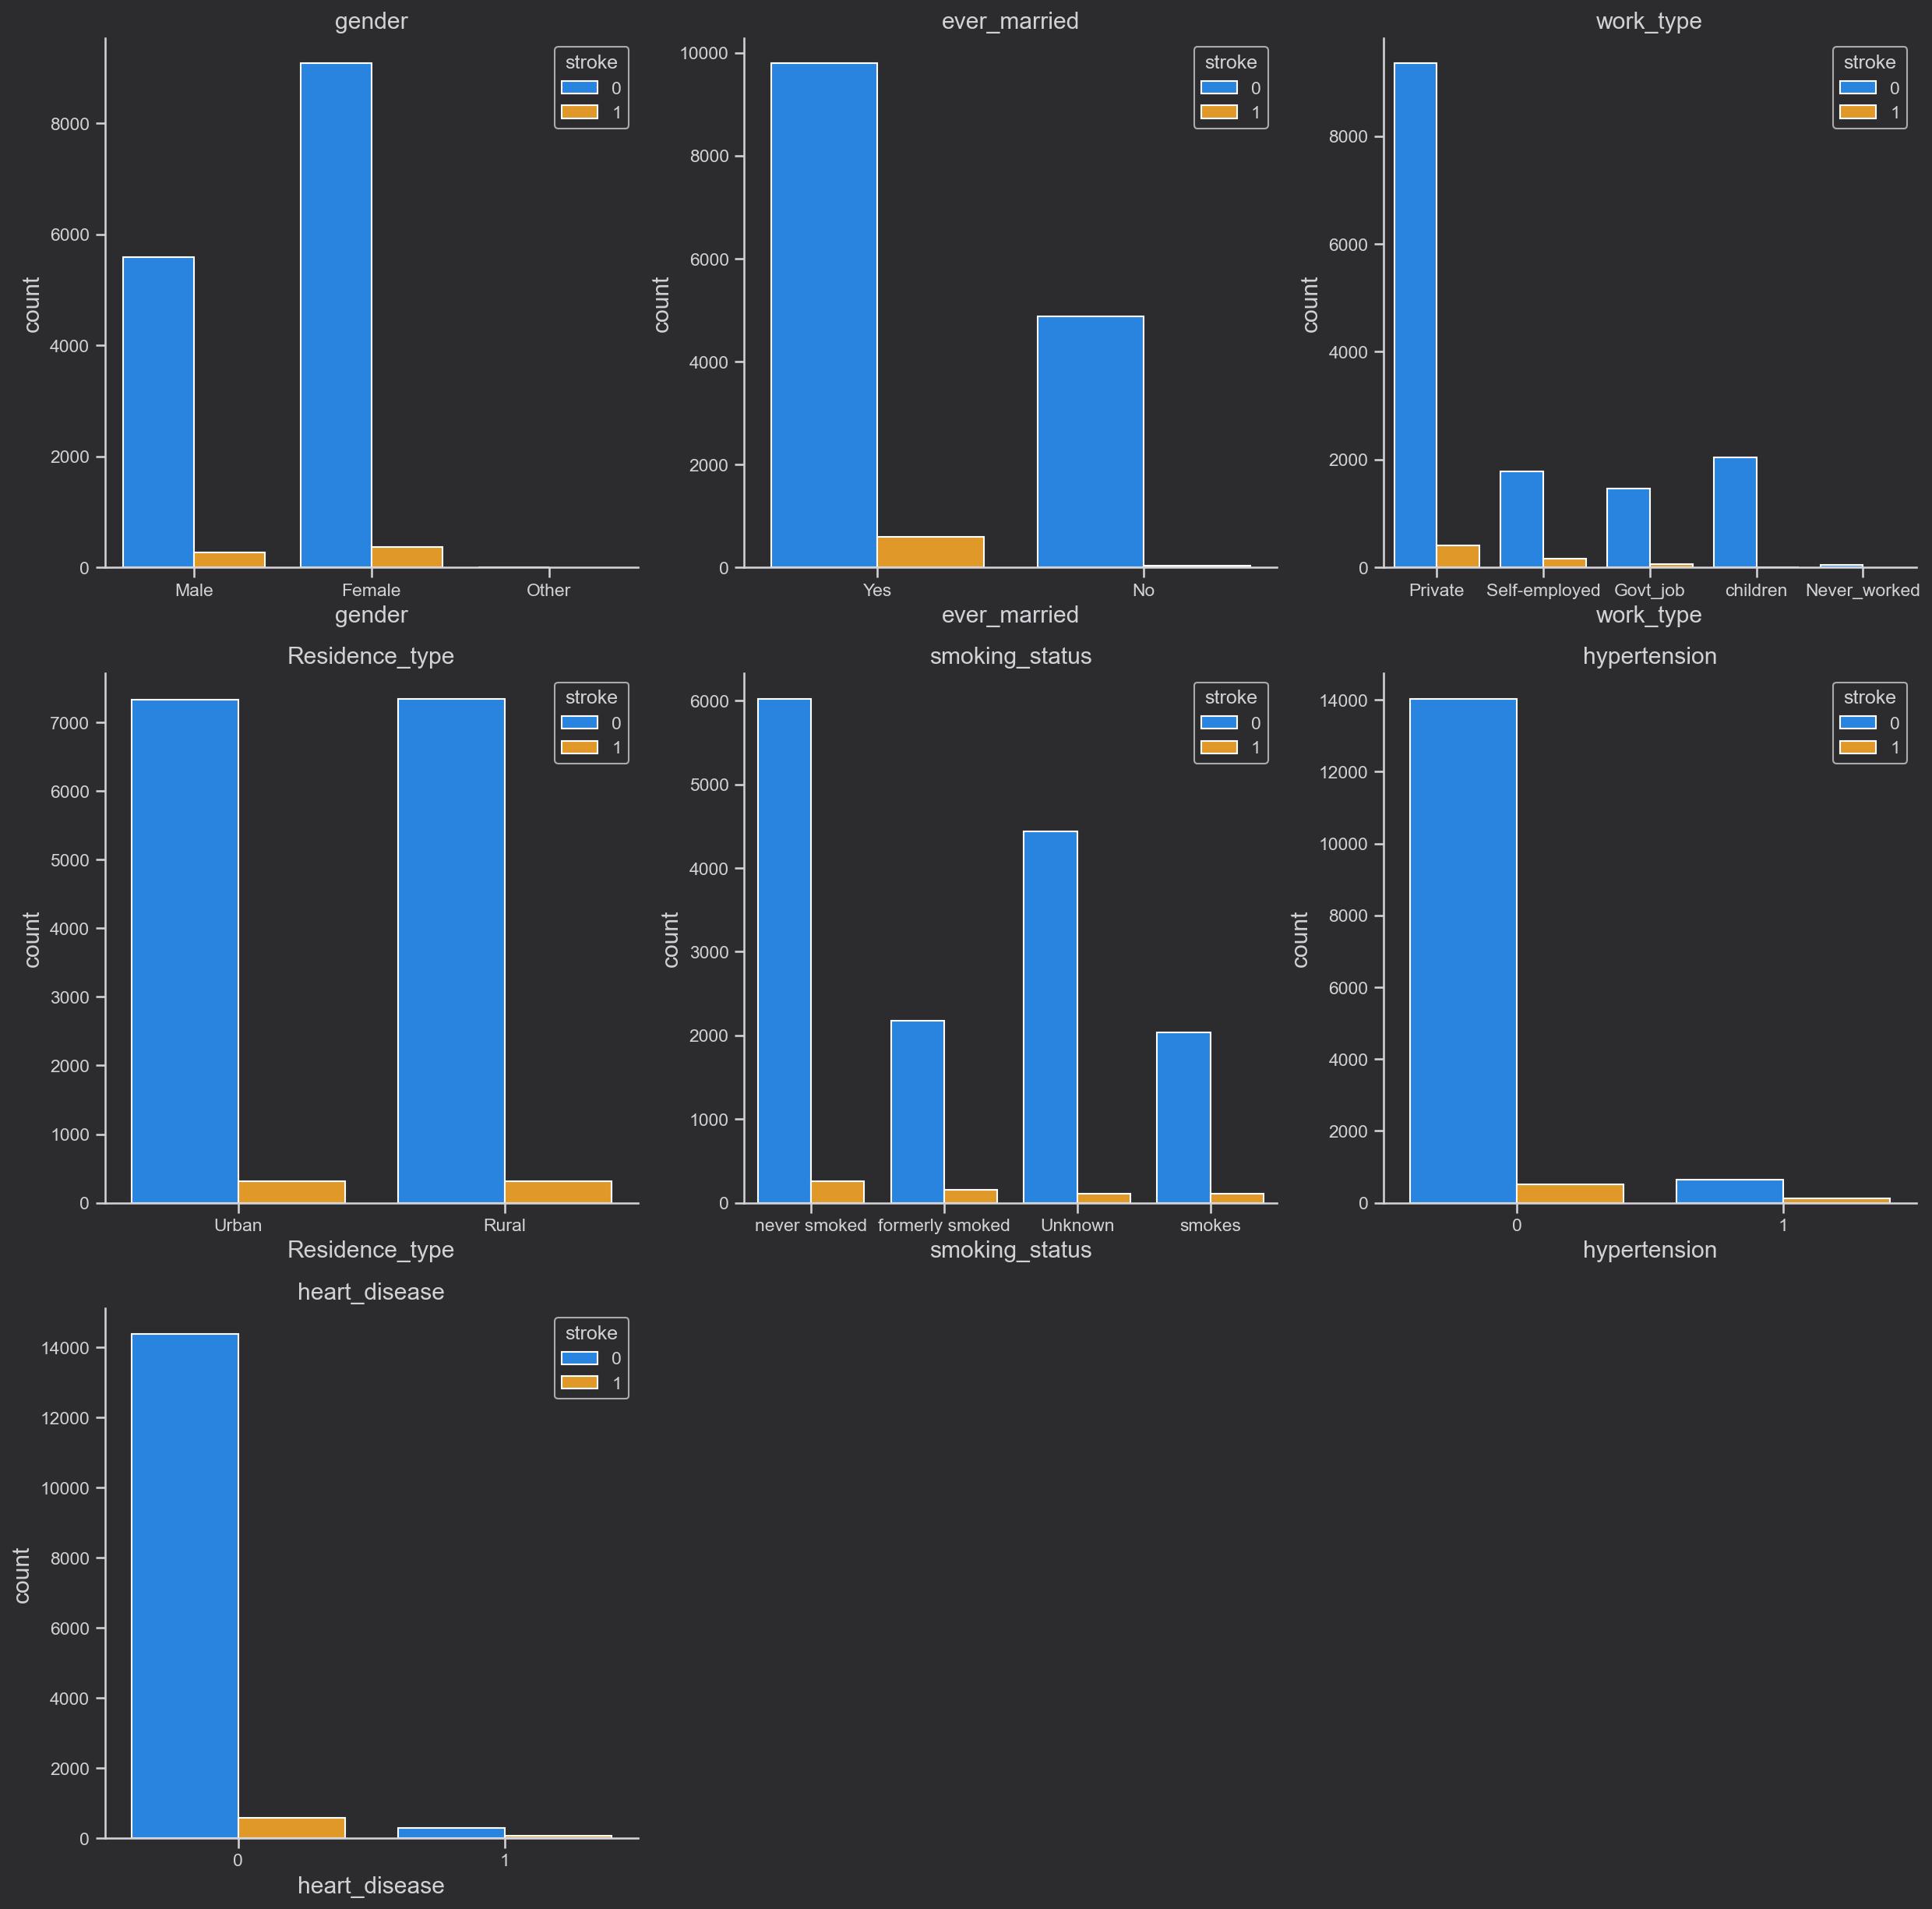

In [661]:
fig = plt.figure(figsize=(20, 20))
col = 3
rows = len(categorical_features.columns) // col + 1

for index, col in enumerate(categorical_features.columns):
    plt.subplot(rows, 3, index + 1)
    sns.countplot(x = col, data=train, hue = "stroke")
    plt.title(col)
    print(index, col)
plt.show()

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>1.2. Bivariate analysis</b>
        </p>
</div>

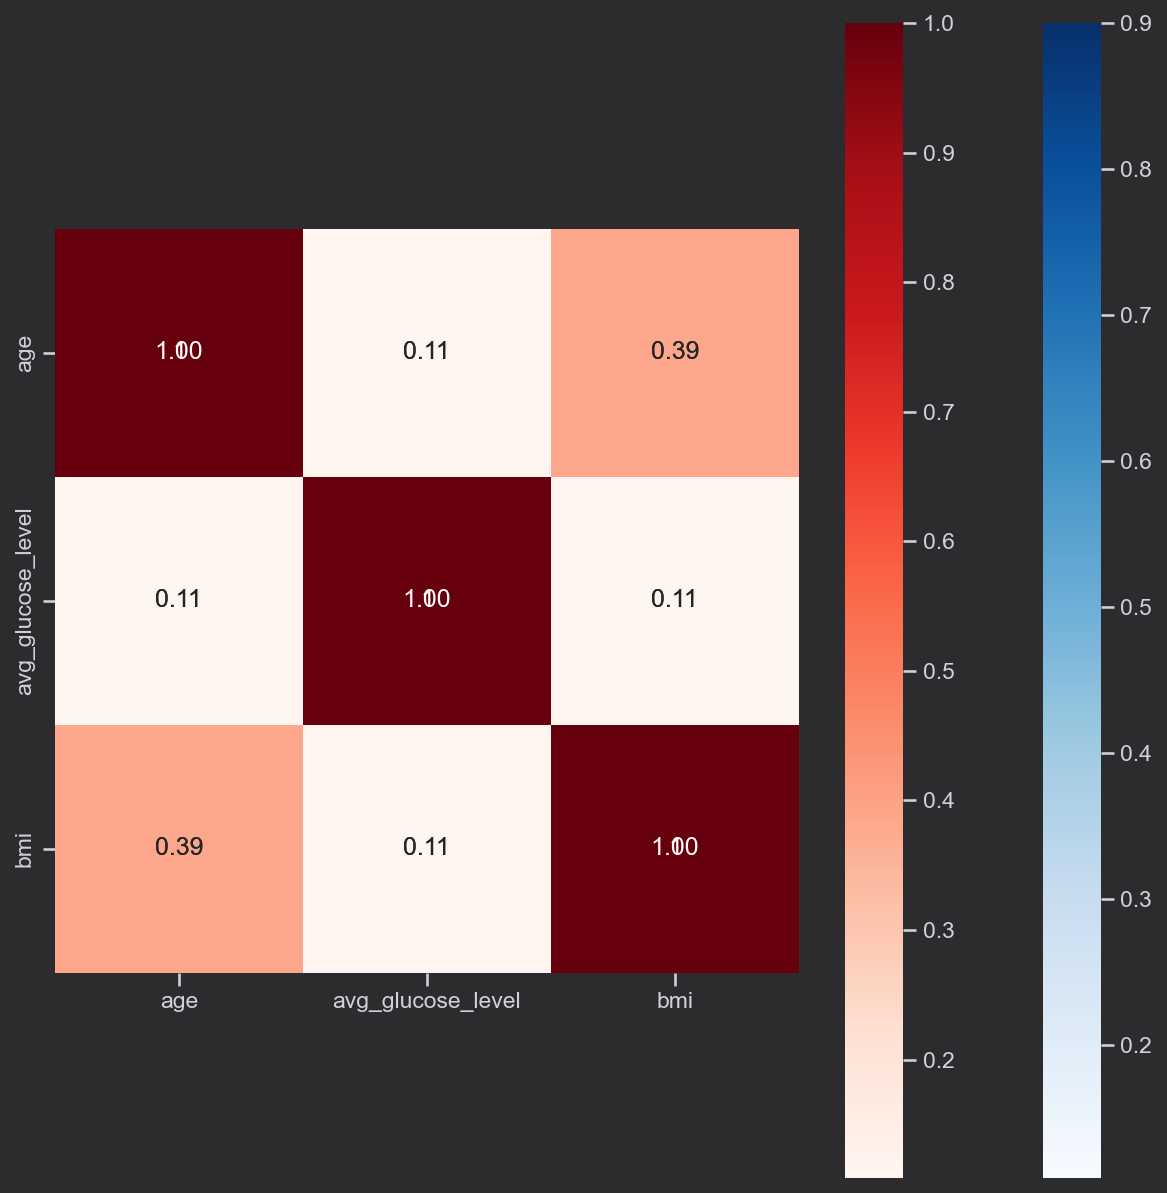

In [662]:
#correlation matrix 

corr = numerical_features.corr()
masked_corr = corr.mask(np.abs(corr)<= 0.7)* corr.mask(np.abs(corr) >= 1)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="Blues", vmax=0.9)
sns.heatmap(corr, annot=True, fmt=".2f", mask=masked_corr, square=True, cmap='Reds')
plt.show()

Bi-variate Analysis for all variables

In [663]:
print(numerical_features.columns.tolist())

['age', 'avg_glucose_level', 'bmi']


In [664]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# float_types = [np.float16, np.float32, np.float64]
# float_columns = train.select_dtypes(include=float_types).columns
# cbar_ax = fig.add_axes([.91, .39, .01, .2])
# vmax, vmin = 0.5, 0

# corr = associations(
#         train, numerical_columns=numerical_features.columns.tolist(),
#         nominal_columns=categorical_features.columns.tolist(),
#         compute_only=True,
#         ax=ax,
#         plot=False
#     )['corr']
    
# mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(
#     corr, mask=mask, cmap='inferno',
#     vmax=vmax, vmin=vmin,
#     center=0, annot=True, fmt='.2f',
#     square=True, linewidths=.1,
#     cbar=True,
#     cbar_ax=cbar_ax,
#     annot_kws={"size": 8}
# )

# fig.tight_layout(rect=[0, 0, .9, 1])
# plt.show()


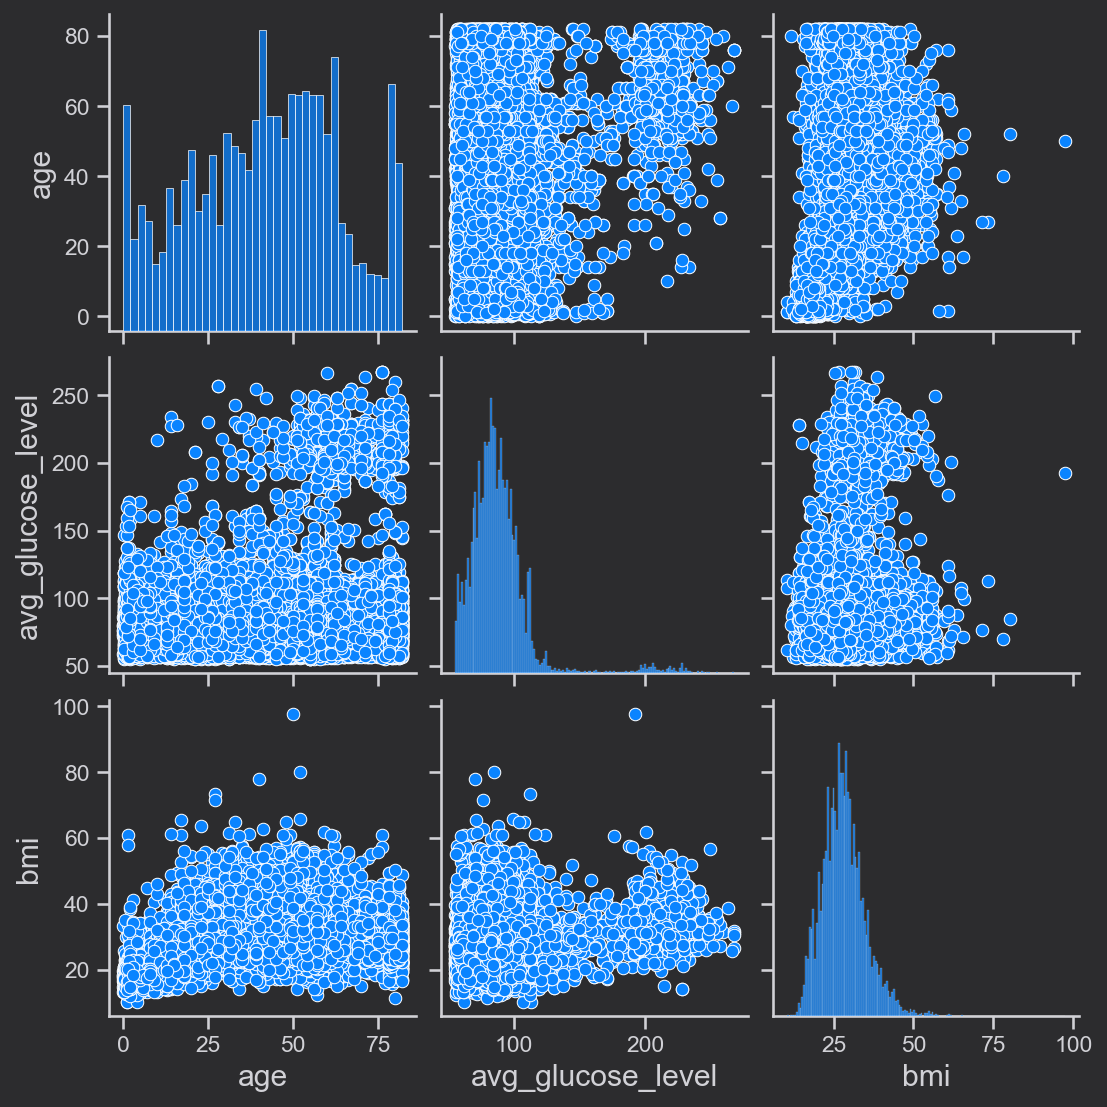

In [665]:
#scatter plot the numerical features for a visual representation of the correlation
sns.pairplot(numerical_features)

<div style="color:#00ADB5;
           display:fill;
           border-radius:10px;
           background-color:#393E46;
           font-size:30px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 5px; padding-left:20px;
              color:white;">
            <b>   2. Data Cleaning</b>
        </p>
</div>

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>2.1. Removing Correlated Features</b>
        </p>
</div>

D'après la matrice de corrélation ci-dessus, il n'y pas de features fortement corrélées que nous devrions enlever

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>2.2. Dealing with NaN</b>
        </p>
</div>

In [666]:
#Display the count of NaN values in each column
print(X.isna().sum())
all_data = pd.concat([train.drop("stroke", axis=1),test], axis=0).reset_index(drop=True).drop("id", axis=1)
stroke = train["stroke"]
print((all_data["smoking_status"] == "Unknown").sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64
7519


In [667]:
#Replacing unknown by never skmoked because the distribution regarding storkes look alike
all_data["smoking_status"].replace({"Unknown": all_data["smoking_status"].mode()[0]}, inplace=True)

C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\3634638194.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data["smoking_status"].replace({"Unknown": all_data["smoking_status"].mode()[0]}, inplace=True)


<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>2.3. Dealing with outliers</b>
        </p>
</div>

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float

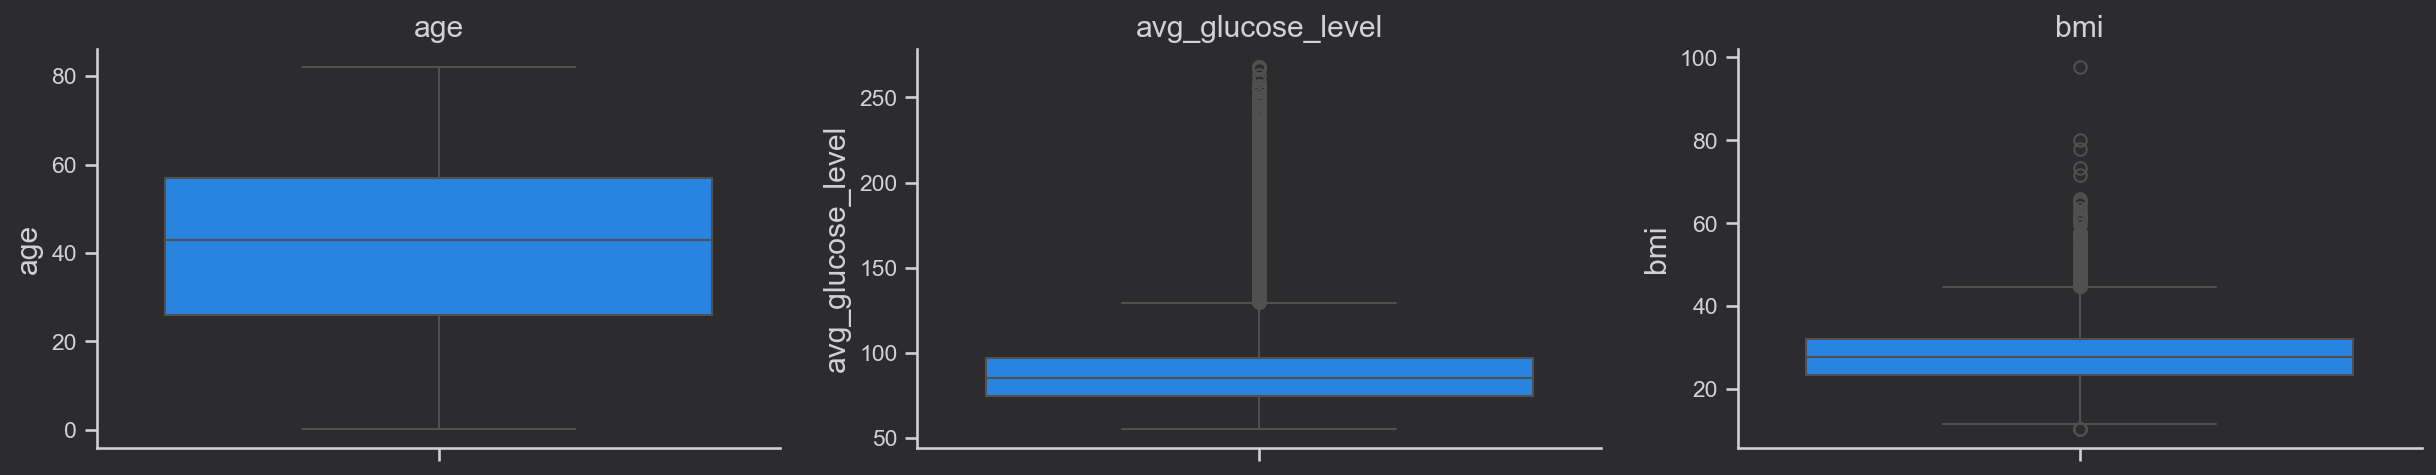

In [668]:
fig = plt.figure(figsize=(20, 20))
col = numerical_features.columns
for index, col in enumerate(numerical_features):
    plt.subplot(5, 3, index + 1)
    sns.boxplot(y = col, data=all_data)
    plt.title(col)

In [669]:
#delete outliers
index = all_data[all_data["bmi"] > 80].index
all_data.drop(index, inplace=True)
#stroke.drop(index, inplace=True)
sns.boxplot(y = "bmi", data=all_data)

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: ylabel='bmi'>

In [670]:


# # final data preprocessing and preperation

# df_copy = all_data.copy()
# # feature log transformations 

# all_data['age'] = all_data['age'].apply(lambda x: np.log(x+10)*3)
# all_data['avg_glucose_level'] = all_data['avg_glucose_level'].apply(lambda x: np.log(x+10)*2)
# all_data['bmi'] = all_data['bmi'].apply(lambda x: np.log(x+10)*2)



# # preprocessing - label enconding and numerical value scaling
# ohe = OneHotEncoder()
# ss = StandardScaler()
# le = LabelEncoder()

# # X = all_data.drop(['stroke','id'], axis = 1)
# # X = all_data
# # y = stroke

# ordinal = ['age_cat',  'glucose_cat', 'bmi_cat','hypertension', 'heart_disease'] # label enconding
# nominal =  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] 
# numerical = ['age','bmi', 'avg_glucose_level'] 

# ## label encoding of ordinal categorical features
# for col in ordinal:
#     X[col] = le.fit_transform(X[col])
    
# ## normalizing with standard scaler of numerical features
# X[numerical] = ss.fit_transform(X[numerical])

# ## norminal data one hot encoding for categorical features
# temp = X.drop(columns = nominal)
# dummies = pd.get_dummies(X[nominal])
# X = pd.concat([temp,dummies], axis = 1)



In [671]:
# # Umap -  Uniform Manifold Approximation and Projection
# umap = umap.UMAP(random_state=2021)
# stroke_umap = umap.fit_transform(X, y)



# fig = plt.figure(figsize=(7,7))# # create figure
# gs = fig.add_gridspec(1, 1)
# gs.update(wspace=0.4, hspace=0.5)
# ax0 = fig.add_subplot(gs[0, 0])


# # Change background color
# background_color = "#f5f6f6"
# fig.patch.set_facecolor(background_color) # figure background color
# ax0.set_facecolor(background_color)


# ax0.scatter(stroke_umap[df['stroke'] == 0][:,0], stroke_umap[df['stroke'] == 0][:,1], c='#512b58', alpha=1,s=50)
# ax0.scatter(stroke_umap[df['stroke'] == 1][:,0], stroke_umap[df['stroke'] == 1][:,1], c='#ff005c', alpha=0.9,s=20)


# ax0.text(-25, 24, 'Clean clustering of all the features can been seen from UMAP tranformation. \nClearly, Strokes, our target can be seen seperated from other features.',fontsize=14, fontfamily='serif')

# ax0.text(-25, 27, 'Visualization of Strokes with UMAP - A Dimension Reduction Technique', 
#         fontsize=18, fontweight='bold', fontfamily='serif')


# for s in ["top","right","left","bottom"]:
#     ax0.spines[s].set_visible(False)
    
# ax0.set_xticks([])
# ax0.set_yticks([])

# fig.text(1,0.8,"Stroke", fontweight="bold", fontfamily='serif', fontsize=18, color='#ff005c')
# fig.text(1.14,0.8,"|", fontweight="bold", fontfamily='serif', fontsize=18, color='black')
# fig.text(1.17,0.8,"No stroke", fontweight="bold", fontfamily='serif', fontsize=18, color='#512b58')

# plt.show()

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>2.3. Mapping features</b>
        </p>
</div>

In [672]:
all_data.head()

gender   age  hypertension  heart_disease ever_married work_type  \
0    Male  28.0             0              0          Yes   Private   
1    Male  33.0             0              0          Yes   Private   
2  Female  42.0             0              0          Yes   Private   
3    Male  56.0             0              0          Yes   Private   
4  Female  24.0             0              0           No   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  
0          Urban              79.53  31.1     never smoked  
1          Rural              78.44  23.9  formerly smoked  
2          Rural             103.00  40.3     never smoked  
3          Urban              64.87  28.8     never smoked  
4          Rural              73.36  28.8     never smoked

In [673]:
#all_data["age"] = pd.cut(all_data["age"], bins = 4, labels=['Young', 'Young adult', 'Adult', 'Senior'])
# pd.cut(all_data["bmi"], bins = 5, index=['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese'])
# pd.cut(all_data["avg_glucose_level"], bins = 5, index=['Low', 'Normal', 'High', 'Very High', 'Extremely High']) 

<div style="color:#00ADB5;
           display:fill;
           border-radius:10px;
           background-color:#393E46;
           font-size:30px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 5px; padding-left:20px;
              color:white;">
            <b>   3. Feature Engineering</b>
        </p>
</div>

In [674]:
#adding features that may seem meaningful
all_data["heart_disease_hypertension"] = all_data["heart_disease"] * all_data["hypertension"]
all_data["avg_glucose_level_bmi"] = all_data["avg_glucose_level"] * all_data["bmi"]
all_data.head()


gender   age  hypertension  heart_disease ever_married work_type  \
0    Male  28.0             0              0          Yes   Private   
1    Male  33.0             0              0          Yes   Private   
2  Female  42.0             0              0          Yes   Private   
3    Male  56.0             0              0          Yes   Private   
4  Female  24.0             0              0           No   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  \
0          Urban              79.53  31.1     never smoked   
1          Rural              78.44  23.9  formerly smoked   
2          Rural             103.00  40.3     never smoked   
3          Urban              64.87  28.8     never smoked   
4          Rural              73.36  28.8     never smoked   

   heart_disease_hypertension  avg_glucose_level_bmi  
0                           0               2473.383  
1                           0               1874.716  
2                           0               4150.900  
3                           0               1868.256  
4                           0               2112.768

In [676]:
all_data['age'] = all_data['age'].apply(lambda x: np.log(x+10)*3)
all_data['avg_glucose_level'] = all_data['avg_glucose_level'].apply(lambda x: np.log(x+10)*2)
all_data['bmi'] = all_data['bmi'].apply(lambda x: np.log(x+10)*2)

In [677]:
df_train_num = train.select_dtypes(exclude=['object']).copy()
df_train_num = df_train_num.drop(["hypertension", "heart_disease"], axis=1)

categorical_features = train.select_dtypes(include=['object']).copy()
categorical_features["hypertension"] = train["hypertension"].astype("object")
categorical_features["heart_disease"] = train["heart_disease"].astype("object")


#Find most important features relative to target
print("Find most important features relative to target")
corr = df_train_num.corr()
corr.sort_values(["stroke"], ascending = False, inplace = True)
corr.stroke.head(11)

Find most important features relative to target


stroke               1.000000
age                  0.261320
avg_glucose_level    0.149273
bmi                  0.065393
id                  -0.017290
Name: stroke, dtype: float64

In [678]:
#add polynomial features for the most important features
all_data["age^2"] = all_data["age"] ** 2
all_data["age^3"] = all_data["age"] ** 3

In [679]:
categorical_features = all_data.select_dtypes(include = ["object"]).columns
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns

# numerical_features = numerical_features.drop(["hypertension", "heart_disease", "heart_disease_hypertension"])
# categorical_features = categorical_features.append(pd.Index(["hypertension", "heart_disease", "heart_disease_hypertension"]))

numerical_features = numerical_features.drop(["hypertension", "heart_disease", ])
categorical_features = categorical_features.append(pd.Index(["hypertension", "heart_disease", ]))

all_data_num = all_data[numerical_features]
all_data_cat = all_data[categorical_features]

all_data_num.head()

age  avg_glucose_level       bmi  heart_disease_hypertension  \
0  10.912758           8.989148  7.432016                           0   
1  11.283600           8.964649  7.046830                           0   
2  11.853731           9.454776  7.836010                           0   
3  12.568964           8.631507  7.316840                           0   
4  10.579082           8.846337  7.316840                           0   

   avg_glucose_level_bmi       age^2        age^3  
0               2473.383  119.088298  1299.581830  
1               1874.716  127.319637  1436.623898  
2               4150.900  140.510942  1665.578935  
3               1868.256  157.978862  1985.630661  
4               2112.768  111.916967  1183.978723

unskew the distributions

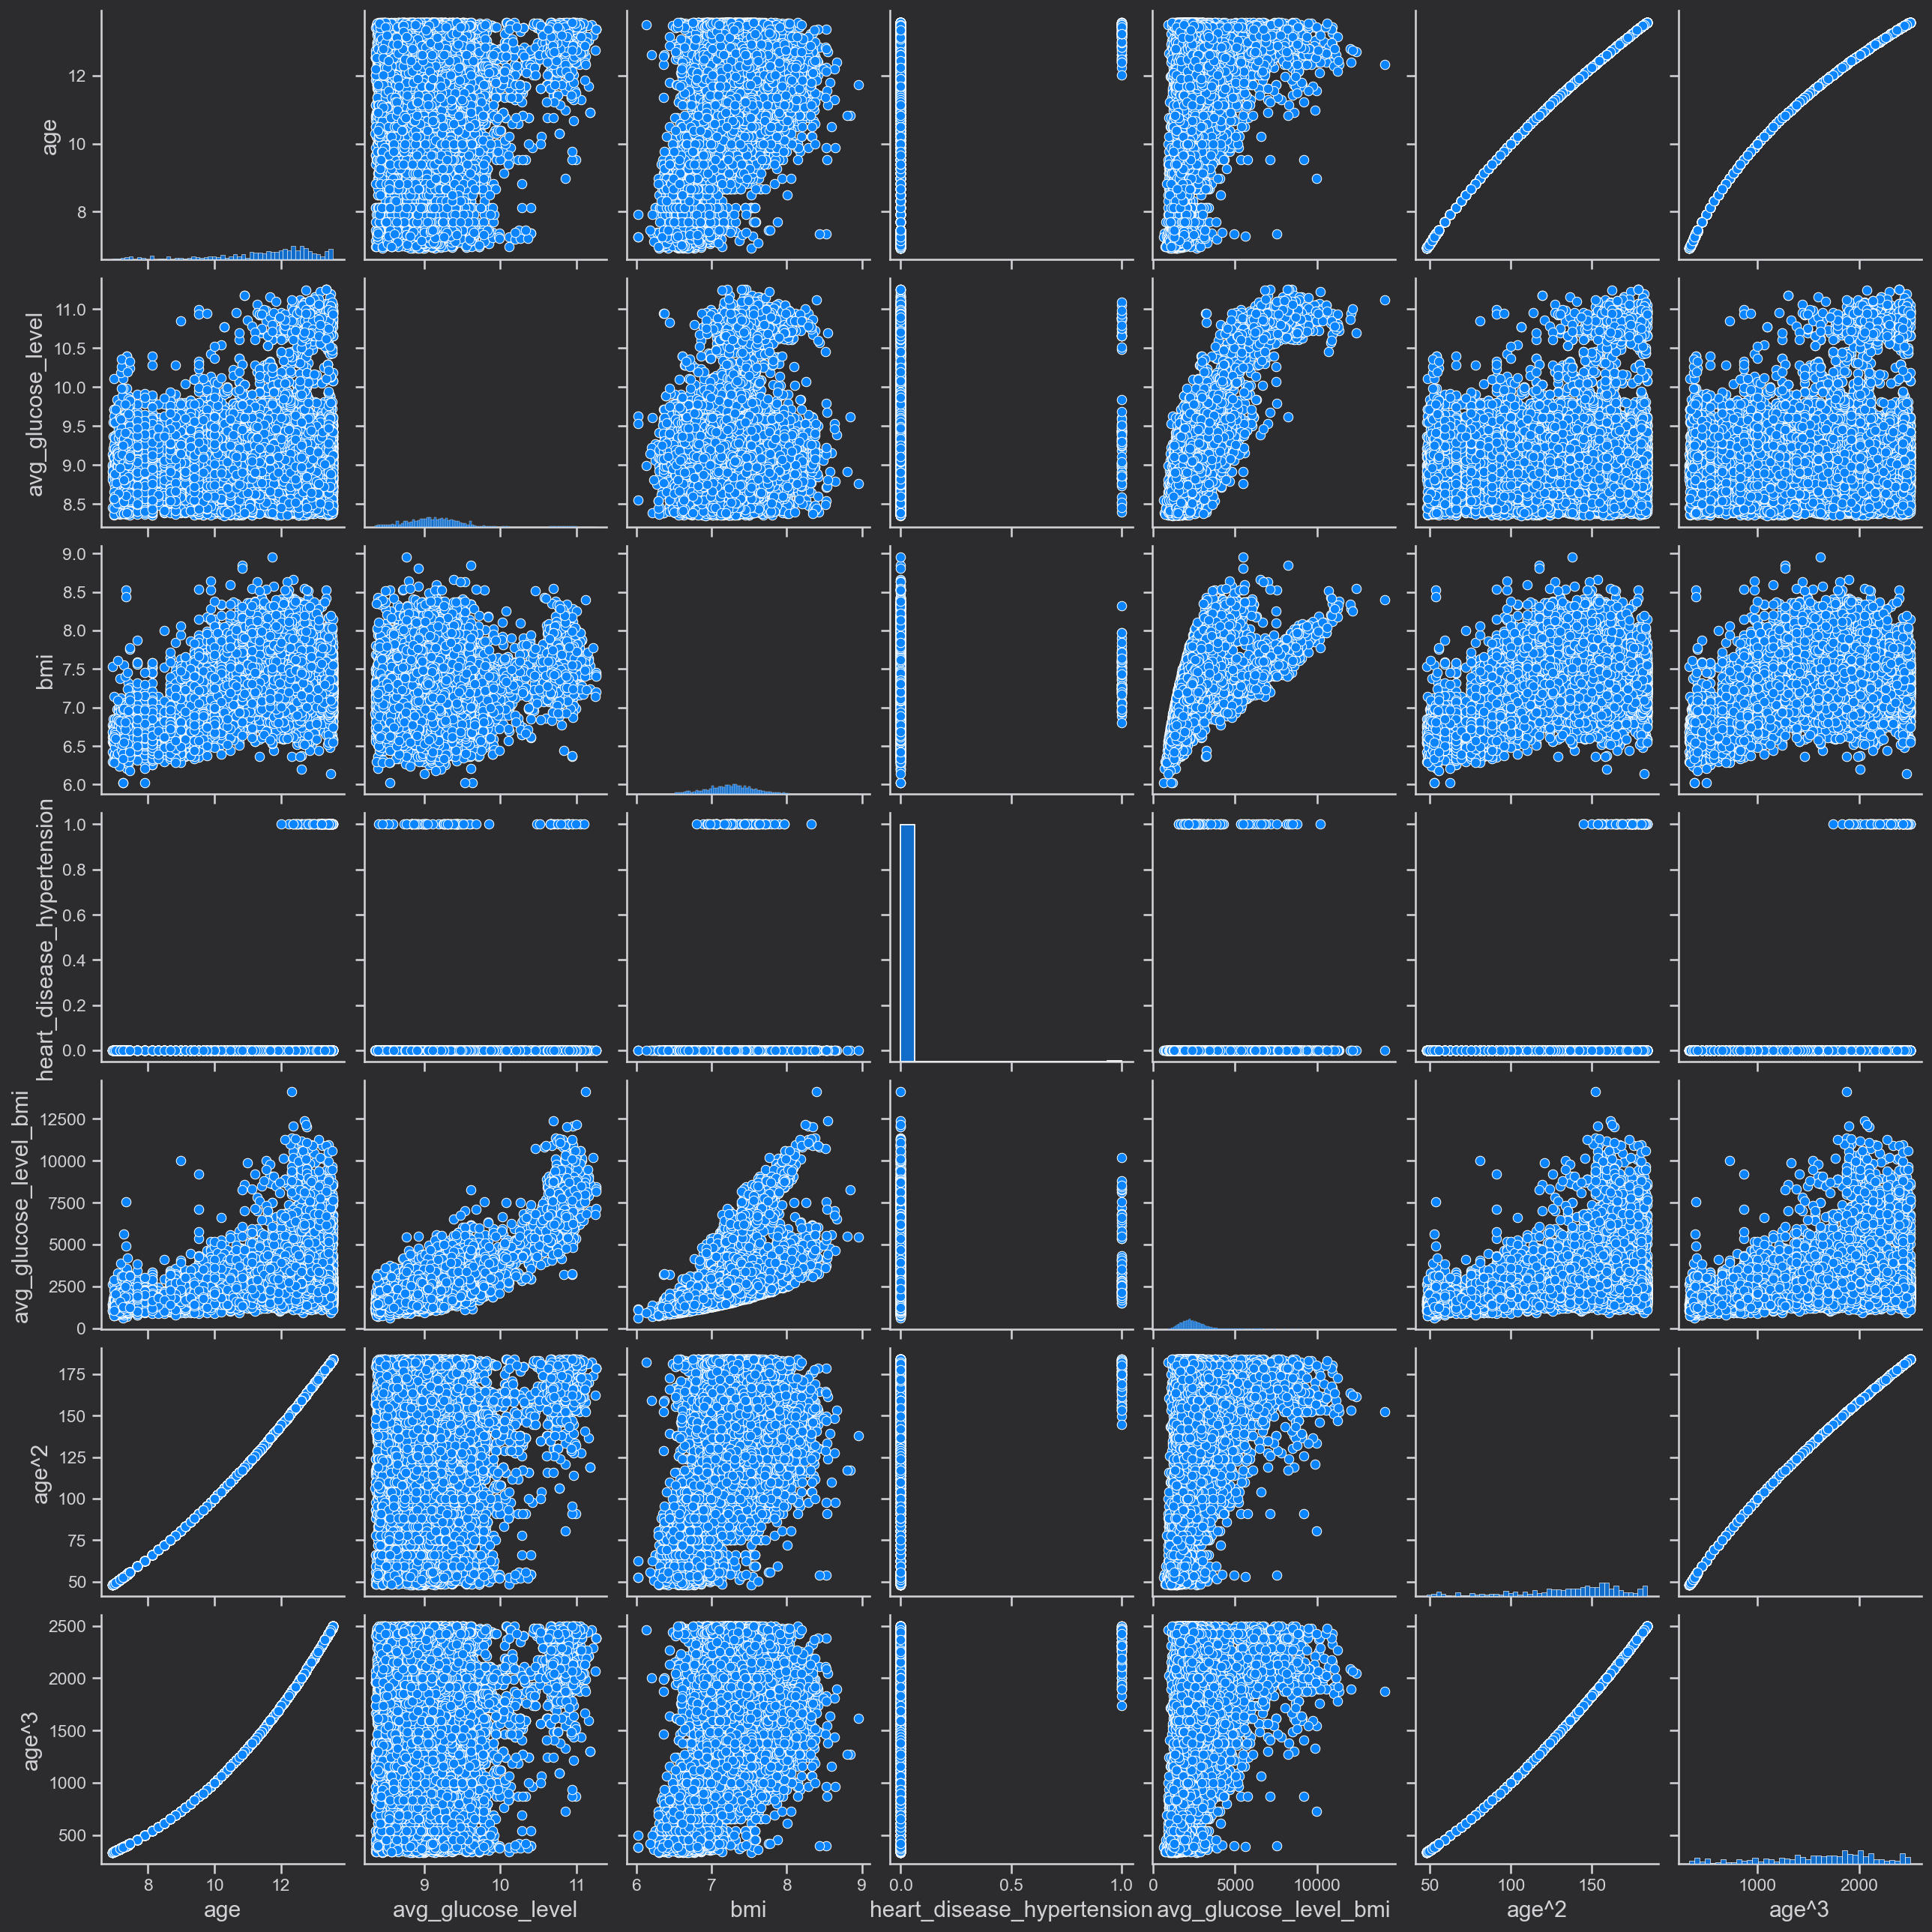

In [680]:
sns.pairplot(all_data_num)

In [681]:
print("NAs for categorical features in train : " + str(all_data_cat.isnull().values.sum()))
all_data_cat["gender"].replace({"Other" : "Male"}, inplace=True)
all_data_cat = pd.get_dummies(all_data_cat, drop_first=True)
print("Remaining NAs for categorical features in train : " + str(all_data_cat.isnull().values.sum()))
all_data_cat.head()

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\3179100571.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data_cat["gender"].replace({"Other" : "Male"}, inplace=True)
C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\3179100571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_cat["gender"].replace({"Other" : "Male"}, inp

hypertension  heart_disease  gender_Male  ever_married_Yes  \
0             0              0         True              True   
1             0              0         True              True   
2             0              0        False              True   
3             0              0         True              True   
4             0              0        False             False   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                   False               True                    False   
1                   False               True                    False   
2                   False               True                    False   
3                   False               True                    False   
4                   False               True                    False   

   work_type_children  Residence_type_Urban  smoking_status_never smoked  \
0               False                  True                         True   
1               False                 False                        False   
2               False                 False                         True   
3               False                  True                         True   
4               False                 False                         True   

   smoking_status_smokes  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False

In [682]:
#compte le nombre de valeurs positives dans hypertension et heart_disease
print(all_data["hypertension"].value_counts())
print(all_data["heart_disease"].value_counts())

hypertension
0    24220
1     1286
Name: count, dtype: int64
heart_disease
0    24928
1      578
Name: count, dtype: int64


In [683]:
# X = pd.concat([all_data_num, all_data_cat], axis=1)


# # Umap -  Uniform Manifold Approximation and Projection
# umap = umap.UMAP()
# stroke_umap = umap.fit_transform(X, y)



# fig = plt.figure(figsize=(7,7))# # create figure
# gs = fig.add_gridspec(1, 1)
# gs.update(wspace=0.4, hspace=0.5)
# ax0 = fig.add_subplot(gs[0, 0])


# # Change background color
# background_color = "#f5f6f6"
# fig.patch.set_facecolor(background_color) # figure background color
# ax0.set_facecolor(background_color)


# ax0.scatter(stroke_umap[all_data['stroke'] == 0][:,0], stroke_umap[all_data['stroke'] == 0][:,1], c='#512b58', alpha=1,s=50)
# ax0.scatter(stroke_umap[all_data['stroke'] == 1][:,0], stroke_umap[all_data['stroke'] == 1][:,1], c='#ff005c', alpha=0.9,s=20)


# ax0.text(-25, 24, 'Clean clustering of all the features can been seen from UMAP tranformation. \nClearly, Strokes, our target can be seen seperated from other features.',fontsize=14, fontfamily='serif')

# ax0.text(-25, 27, 'Visualization of Strokes with UMAP - A Dimension Reduction Technique', 
#         fontsize=18, fontweight='bold', fontfamily='serif')


# for s in ["top","right","left","bottom"]:
#     ax0.spines[s].set_visible(False)
    
# ax0.set_xticks([])
# ax0.set_yticks([])

# fig.text(1,0.8,"Stroke", fontweight="bold", fontfamily='serif', fontsize=18, color='#ff005c')
# fig.text(1.14,0.8,"|", fontweight="bold", fontfamily='serif', fontsize=18, color='black')
# fig.text(1.17,0.8,"No stroke", fontweight="bold", fontfamily='serif', fontsize=18, color='#512b58')

# plt.show()

<div style="color:#00ADB5;
           display:fill;
           border-radius:10px;
           background-color:#393E46;
           font-size:30px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 5px; padding-left:20px;
              color:white;">
            <b>   4. Modeling</b>
        </p>
</div>

In [684]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score,precision_score, f1_score, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
#import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>4.1. Split Data (Train/Test)</b>
        </p>
</div>

In [685]:
len_train = train.shape[0]
print(len_train)
len_test = test.shape[0]
print(len_test)
print(len(all_data))

15304
10204
25506


In [686]:
all_data = pd.concat([all_data_num, all_data_cat], axis = 1)
df_train = all_data[:len_train]
df_test = all_data[len_train:]

numerical_features = all_data_num.columns
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(df_train, stroke, test_size = 0.20, random_state = 0, shuffle=True)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))


X_train : (12243, 18)
X_test : (3061, 18)
y_train : (12243,)
y_test : (3061,)


In [687]:
pd.concat([X_train, y_train], axis=1)

age  avg_glucose_level       bmi  heart_disease_hypertension  \
7687   10.579082           9.204933  7.070291                         0.0   
6249   11.675461           9.083396  6.956317                         0.0   
11397  12.181329           9.611318  7.522400                         0.0   
7004   12.429404          11.009443  7.172586                         0.0   
3733   12.523162           8.391996  7.099235                         0.0   
...          ...                ...       ...                         ...   
6216         NaN                NaN       NaN                         NaN   
5874         NaN                NaN       NaN                         NaN   
13123        NaN                NaN       NaN                         NaN   
9845         NaN                NaN       NaN                         NaN   
10799        NaN                NaN       NaN                         NaN   

       avg_glucose_level_bmi       age^2        age^3  hypertension  \
7687                2180.439  111.916967  1183.978723           0.0   
6249                1878.240  136.316387  1591.556647           0.0   
11397               3702.600  148.384777  1807.523792           0.0   
7004                6155.685  154.490088  1920.219749           0.0   
3733                1399.216  156.829582  1964.002228           0.0   
...                      ...         ...          ...           ...   
6216                     NaN         NaN          NaN           NaN   
5874                     NaN         NaN          NaN           NaN   
13123                    NaN         NaN          NaN           NaN   
9845                     NaN         NaN          NaN           NaN   
10799                    NaN         NaN          NaN           NaN   

       heart_disease gender_Male ever_married_Yes work_type_Never_worked  \
7687             0.0       False            False                  False   
6249             0.0        True             True                  False   
11397            0.0       False             True                  False   
7004             0.0       False             True                  False   
3733             0.0        True             True                  False   
...              ...         ...              ...                    ...   
6216             NaN         NaN              NaN                    NaN   
5874             NaN         NaN              NaN                    NaN   
13123            NaN         NaN              NaN                    NaN   
9845             NaN         NaN              NaN                    NaN   
10799            NaN         NaN              NaN                    NaN   

      work_type_Private work_type_Self-employed work_type_children  \
7687               True                   False              False   
6249               True                   False              False   
11397             False                   False              False   
7004               True                   False              False   
3733               True                   False              False   
...                 ...                     ...                ...   
6216                NaN                     NaN                NaN   
5874                NaN                     NaN                NaN   
13123               NaN                     NaN                NaN   
9845                NaN                     NaN                NaN   
10799               NaN                     NaN                NaN   

      Residence_type_Urban smoking_status_never smoked smoking_status_smokes  \
7687                 False                        True                 False   
6249                 False                        True                 False   
11397                False                        True                 False   
7004                 False                        True                 False   
3733                 False                        True                 False   
.

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>4.2. Scaling of the Data</b>
        </p>
</div>

In [688]:
stdSC = StandardScaler()
X_train.loc[:, numerical_features] = stdSC.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSC.transform(X_test.loc[:, numerical_features])
df_test.loc[:, numerical_features] = stdSC.transform(df_test.loc[:, numerical_features])

#SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
#count the number of strokes in the resampled data
print(X_train_res.shape)

(23462, 18)


C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\3355431822.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.06005708 -0.06005708 -0.06005708 ... -0.06005708 -0.06005708
 -0.06005708]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_features] = stdSC.fit_transform(X_train.loc[:, numerical_features])
C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\3355431822.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.06005708 -0.06005708 -0.06005708 ... -0.06005708 -0.06005708
 -0.06005708]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:, numerical_features] = stdSC.transform(X_test.loc[:, numerical_features])
C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\3355431822.py:4: FutureWarning: Setting an item of incompatibl

In [689]:
def model_evaluation(actual,pred):
    print('Recall:    ',recall_score(actual,pred),end='\n')
    print('Precision: ',precision_score(actual,pred),end='\n')
    print('Accuracy:  ',accuracy_score(actual,pred),end='\n')
    print('F1 score:  ',f1_score(actual,pred),end='\n')
 
    cm = confusion_matrix(actual,pred)
    sns.heatmap(cm, annot=True,fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title("confusion matrix")
    plt.show()

<div style="color:black;
           border-radius:10px;
           background-color:#00ADB5;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px; padding-left: 10px;
              color:white;">
            <b>4.2. Training Algorithms</b>
        </p>
</div>

In [690]:
def predictions(x_set,y_set):
    print('Classification Process Starts....')
    accuracy,precision,recall,f1,auc,conf_mat= [],[],[],[],[],[]
        
    random_state = 2021
    
    ##classifiers list 
    classifiers = []
    classifiers.append(SVC(random_state=random_state, probability = True))
    classifiers.append(DecisionTreeClassifier(random_state=random_state))
    classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state)))
    classifiers.append(RandomForestClassifier(random_state=random_state))
    classifiers.append(GradientBoostingClassifier(random_state=random_state))
    classifiers.append(KNeighborsClassifier())
    classifiers.append(LogisticRegression(random_state = random_state))
    classifiers.append(XGBClassifier(random_state = random_state))

    for classifier in classifiers:
        
        print('fitting on classifier with parameters: {}'.format(classifier))
        
        #classifier and fitting
        clf = classifier
        clf.fit(x_set,y_set)
        
        #predictions
        y_preds = clf.predict(X_test)
        y_probs = clf.predict_proba(X_test)
        
        # metrics
        accuracy.append((round(accuracy_score(y_test,y_preds),2))*100)
        precision.append((round(precision_score(y_test,y_preds),2))*100)
        recall.append((round(recall_score(y_test,y_preds),2))*100)
        f1.append((round(f1_score(y_test,y_preds),2))*100)
        auc.append((round (roc_auc_score(y_test,y_probs[:,1]), 2))*100)
        conf_mat.append(confusion_matrix(y_test,y_preds))
        
        print('\n')
    results_df = pd.DataFrame({"Accuracy Score":accuracy,"Precision Score":precision,
                        "Recall Score":recall, "f1 Score":f1,"AUC Score":auc,
                        "Confusion Matrix":conf_mat,
                        "Algorithm":["SVC","DecisionTree","AdaBoost",
                                     "RandomForest","GradientBoosting",
                                     "KNeighboors","LogisticRegression",
                                     "XGBoost"]})
    
    results_df = (results_df.sort_values(by = 'Algorithm', ascending = False)
                  .reset_index(drop =  True))
    print('***************************************************************\n\n')
    
    return results_df

In [691]:
orig_results = predictions(X_train,y_train)
resamp_results = predictions(X_train_res,y_train_res)

Classification Process Starts....
fitting on classifier with parameters: SVC(probability=True, random_state=2021)


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




fitting on classifier with parameters: DecisionTreeClassifier(random_state=2021)


fitting on classifier with parameters: AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=2021))


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(




fitting on classifier with parameters: RandomForestClassifier(random_state=2021)


fitting on classifier with parameters: GradientBoostingClassifier(random_state=2021)


fitting on classifier with parameters: KNeighborsClassifier()


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




fitting on classifier with parameters: LogisticRegression(random_state=2021)


fitting on classifier with parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=2021, ...)


***************************************************************


Classification Process Starts....
fitting on classifie

In [ ]:
def multi_visualize(data, vmin = -0.5, vmax = 1):
    fig = plt.figure(figsize =(24,24))
    gs = fig.add_gridspec(8,6)
    gs.update(wspace = 0.2, hspace = 0.1)
    
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])
    
    ax7 = fig.add_subplot(gs[2,0])
    ax8 = fig.add_subplot(gs[2,1])
    ax9 = fig.add_subplot(gs[2,2])
    
    ax10 = fig.add_subplot(gs[0,3])
    ax11 = fig.add_subplot(gs[0,4])
    ax12 = fig.add_subplot(gs[0,5])
    
    ax13 = fig.add_subplot(gs[1,3])
    ax14 = fig.add_subplot(gs[1,4])
    ax15 = fig.add_subplot(gs[1,5])
    
    ax16 = fig.add_subplot(gs[2,3])
    ax17 = fig.add_subplot(gs[2,4])
    ax18 = fig.add_subplot(gs[2,5])
    
    
    axes1 = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    axes2 = [ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17]
    
    axes = [axes1,axes2]
    
    fig.patch.set_facecolor('#f6f5f5')
    
    # setting of axes; visibility of axes and spines turn off
    for ax_list in axes:
        for ax in ax_list:
            ax.axes.get_yaxis().set_visible(False)
            ax.axes.get_xaxis().set_visible(False)
            ax.set_facecolor('#f6f5f5')

    colors = ['#512b58','#fe346e']
    
    
    for ax_list in axes:
        
        if ax_list == axes1:
            res_df = data[0]
        else:
            res_df = data[1]
        
        
        alg = res_df['Algorithm']
        cf = res_df['Confusion Matrix']
        auc = res_df['AUC Score']
        f1 = res_df['f1 Score']
        forig = data[0]['f1 Score']
        fresam = data[1]['f1 Score']
        
        n = 0
        for ax in ax_list:
            cf_mat = cf[n]
            
            #### annotations
            labels = ['True Neg','False Pos','False Neg','True Pos']
            counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
            percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten()/np.sum(cf_mat)]
            
            #### final annotations
            label = (np.array([f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,counts,percentages)])).reshape(2,2)
            
            #### heatmap
            sns.heatmap(data = cf_mat, vmin = vmin, vmax =vmax, cmap = ['grey'],linewidth=2,linecolor = '#f6f5f5',
               ax = ax, annot = label, fmt ='', cbar = False, annot_kws = {'font':'serif','size':10, 'color':'white','weight':'bold'}, alpha =0.8)
            
            #### subtitle
            if ax_list == axes1:
                ax.text(0,-0,'{}'.format(alg[n]),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
            else:
                ax.text(0,-0,'SMOTE {}'.format(alg[n]),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
           
        
            #### Auc and F1 score plotting
            
            if ax_list == axes2:
                if (fresam[n] > forig[n]) & (auc[n] > 75):
                    ax.scatter( 1 , 1 , s = 3500, c = '#fe346e')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
                else:
                    ax.scatter( 1 , 1 , s = 3500, c = 'white')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
               
            else:
                if (forig[n] > 5 ) & (auc[n] > 75):
                    ax.scatter( 1 , 1 , s = 3500, c = '#512b58', alpha = 0.9)
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'white', 'weight':'bold'})
                else:
                    ax.scatter( 1 , 1 , s = 3500, c = 'white')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
            
           
            n +=1
        if ax_list == axes1:
            ax1.text(0,-0.55,'Visualization of Results with - Original Data',{'font':'serif','size':24, 'color':'black', 'weight':'bold'},)
        else:
            ax10.text(0,-0.55,'Visualization of Results with - Oversampled Data',{'font':'serif','size':24, 'color':'black', 'weight':'bold'}, alpha = 0.9)
            
            
    fig.show()

In [ ]:
multi_visualize(data = [orig_results, resamp_results], vmin=30,vmax = 100)

C:\Users\ilias\AppData\Local\Temp\ipykernel_15060\3592555482.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:

xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)
y_pred = xgb.predict(X_test)
# accuracy on the training set
print("Accuracy on training set: ", xgb.score(X_train_res, y_train_res))
# confusion matrix on the training set
model_evaluation(y_test, y_pred)


Accuracy on training set:  0.9410109965049868
Recall:     0.11666666666666667
Precision:  0.04929577464788732
Accuracy:   0.8771643253838615
F1 score:   0.06930693069306931


In [ ]:
y_test.value_counts()

stroke
0    2941
1     120
Name: count, dtype: int64

In [ ]:
#ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(max_depth=100, random_state=0, class_weight={0:10, 1:1})
etc.fit(X_train_res, y_train_res)
y_pred = etc.predict(X_test)
y_pred_proba = etc.predict_proba(X_test)[:, 1]
model_evaluation(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc}')


Recall:     0.03333333333333333
Precision:  0.031746031746031744
Accuracy:   0.9222476314929762
F1 score:   0.032520325203252036


ROC AUC Score: 0.5140711776039896


In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight={0:1, 1:1})
lr.fit(X_train_res, y_train_res)
y_pred = lr.predict(X_test)
model_evaluation(y_test,y_pred)
#print the ROC AUC score
y_pred_proba = lr.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc}')


Recall:     0.4166666666666667
Precision:  0.04859086491739553
Accuracy:   0.6573015354459327
F1 score:   0.08703220191470844


ROC AUC Score: 0.528921568627451
